Define values for Data Points

In [2800]:
!pip install numpy
!pip install pandas 
!pip install matplotlib
!pip install scikit-learn

In [2801]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans

# Define Sigma Values

In [2802]:
sigma_list = np.linspace(0.1,2, num = 20 ,dtype=float)
sigma_list=np.round(sigma_list,1)
print(sigma_list)
print(sigma_list.shape)

# sigma_list= [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,12]

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ]
(20,)


# Initialise performance variables

In [2803]:
accuracy_list_1=[]
accuracy_list_2=[]
accuracy_list_3=[]
mse_list_1=[]
mse_list_2=[]
mse_list_3=[]
tst_accuracy_list_1=[]
tst_accuracy_list_2=[]
tst_accuracy_list_3=[]
tst_mse_list_1=[]
tst_mse_list_2=[]
tst_mse_list_3=[]


In [2804]:
weights_1=[]
weights_2=[]
weights_3=[]

centres_1=[]
centres_2=[]
centres_3=[]



In [2805]:
np.random.seed(1)

# Functions to create Dataset

In [2806]:
#Here i=0,1,2...20, returns float
def value_func(i):
    return round(-2+0.2*i,2)

# Returns list of values that x1,x2 can take
def value_gen(max_val):
    i_list = np.linspace(0, 20, num = 21,dtype=int)
    print("Range of i and j is : ",i_list) # Gives the range of i,j
    values_list=list(map(value_func,i_list))
    print("List of values",values_list)
    return values_list

#Returns a 441x2 np_array which is the training data. 441 samples with 2 input features each
def random_train_samples(value_list):
    train_data = []
    for num_samples in range(441):
        row = []  
        for num_features in range(2):
            row.append(random.choice(value_list))
        train_data.append(row) 
    train_data=np.array(train_data)
    return train_data

# train_pt is a 1x2 np array, returns int
def squared_sum(train_pt):
    return (train_pt[0]**2)+(train_pt[1]**2)

# Returns a 441x1 np array containing the output labels as per f(x1,x2)
def train_labels(train_data):
    labels=[]       #Output Labels
    square_sum=[]   # To evaluate (x1^2 + x2^2) , returns (441,1)
    for i in range(train_data.shape[0]):
        square_sum.append(squared_sum(train_data[i]))
        if squared_sum(train_data[i])<=1:
            labels.append(1)
        else:
            labels.append(-1)
    labels=np.array(labels)
    labels=np.reshape(labels,(441,1))
    square_sum=np.array(square_sum)
    square_sum=np.reshape(square_sum,(441,1))
    return labels,square_sum


def train_test_split(X,Y):
    
    # Shuffled indices of samples
    shuffled_indices=np.random.permutation(np.arange(X.shape[0]))

    X_shuff= X[shuffled_indices]
    Y_shuff= Y[shuffled_indices]

    # Ratio of Training Samples
    train_split = 0.8
    num_train = int(train_split*X_shuff.shape[0])

    # Training Data
    X_train= X_shuff[:num_train]
    Y_train= Y_shuff[:num_train]

    # Validation Data
    X_val= X_shuff[num_train:]
    Y_val = Y_shuff[num_train:]
    
    return X_train,Y_train,X_val,Y_val


# Functions to create Centres

In [2807]:
#returns rbf centres-441x2 matrix
def rbf_centres_all(train_data):
    return train_data

def rbf_centres_random(train_data):
    rbf_centres =np.empty((150,2))
    for num_samples in range(150):
        rbf_centres[num_samples]=random.choice(train_data)
    return rbf_centres

# def rbf_centres_random(train_data):
#     n = train_data.shape[0]

#     random_args = np.random.choice(n,150)
#     centers = train_data[random_args]
#     return centers

def rbf_centres_kmeans(train_data,K):
#     kmeans = KMeans(n_clusters=K,n_init='auto').fit(train_data)
    kmeans = KMeans(n_clusters=K,random_state=0).fit(train_data)
    centres=kmeans.cluster_centers_
    return centres


# Functions for Interpolation

In [2808]:
def gaussian_kernel(ip_array, center_vector, sigma):
    x=np.exp(-np.linalg.norm(ip_array - center_vector)**2 / (2 * sigma**2))
    return x



def rbf(train_data,centres,sigma):
    phi = np.zeros((train_data.shape[0], centres.shape[0]))
    print("Shape of phi is:",phi.shape)
    for i in range(train_data.shape[0]):
        for j in range(centres.shape[0]):
            phi[i, j] = gaussian_kernel(train_data[i], centres[j], sigma)
    return phi

def weights(rbf_output,op_labels):
    G_pinv=np.linalg.pinv(rbf_output)
    D=op_labels
    W=np.dot(G_pinv,D)
    return W

def predict(W,G):
#     Y=np.dot(W.T,G)
    Y=np.dot(G,W)
    Y=np.array(Y)
    Y=np.sign(Y)
    return Y


# Functions to evaluate performance

In [2809]:
def calculate_accuracy(pred_op,actual_op):
    accuracy = np.mean(pred_op == actual_op) * 100
    return accuracy

def calculate_mse(pred_op,actual_op):
    mse= np.mean((pred_op - actual_op) ** 2)*100
    return mse


# Functions to visualise data

In [2810]:

def plot(train_data, labels, ptype):
    inside_circle = train_data[labels.flatten() == 1.0]
    outside_circle = train_data[labels.flatten() == -1.0]
    plot_type = {1: "Train Points", 2: "RBF-All", 3: "RBF-Random", 4: "RBF-KMeans"}


    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot inside circle points
    ax.scatter(inside_circle[:, 0], inside_circle[:, 1], color='orangered', label='Inside Circle')
    
    # Plot outside circle points 
    ax.scatter(outside_circle[:, 0], outside_circle[:, 1], color='mediumblue', label='Outside Circle')
    

    ax.set_xlabel('x1', fontsize=12)
    ax.set_ylabel('x2', fontsize=12)
    ax.set_title('Points Inside and Outside Circle - ' + plot_type[ptype], fontsize=14, fontweight='bold')

    ax.legend(fontsize=10)
    ax.grid(True, linestyle='--', alpha=0.5)
    fig.tight_layout()
    plt.show()


In [2811]:
def acc_mse_plot(perc_list,sig_list,mse=False):
    
    plt.figure(figsize=(16,10))
    plt.plot(sig_list, perc_list, marker='o', linestyle='-', color='b')
    
    plt.xlabel('Sigma',fontsize=12)
    if mse:
        plt.ylabel('Mean Squared Error in %',fontsize=12)
        plt.title('Sigma v/s MSE Graph',fontsize=12,fontweight='bold')
    else:
        plt.ylabel('Accuracy in %',fontsize=12)
        plt.title('Sigma v/s Accuracy Graph',fontsize=12,fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()  

In [2812]:
def comp_plot(acc_list_1,acc_list_2,acc_list_3,sig_list,mse=False):
    
    plt.figure(figsize=(16,10))
    
    if mse:
        plt.plot(sig_list,mse_list_1,marker='o', linestyle='-',color="red",label="All")
        plt.plot(sig_list,mse_list_2,marker='o', linestyle='--',color="blue",label="Random")
        plt.plot(sig_list,mse_list_3,marker='o', linestyle='-.',color="green",label="KMeans")
        plt.xlabel('Sigma',fontsize=12)
        plt.ylabel('MSE in %',fontsize=12)
        plt.title('Sigma v/s MSE Graph',fontsize=12,fontweight='bold')
        
    else:
        plt.plot(sig_list,acc_list_1,marker='o', linestyle='-',color="red",label="All")
        plt.plot(sig_list,acc_list_2,marker='o', linestyle='--',color="blue",label="Random")
        plt.plot(sig_list,acc_list_3,marker='o', linestyle='-.',color="green",label="KMeans")
        plt.xlabel('Sigma',fontsize=12)
        plt.ylabel('Accuracy in %',fontsize=12)
        plt.title('Sigma v/s Accuracy Graph',fontsize=12,fontweight='bold')
    
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.legend(fontsize=10)
    plt.tight_layout()

# RBF Function

In [2813]:
def RBF_NN(train_data,op_labels,sigma,quest,K=None):
    
    if quest==1:
        rbf_centres=rbf_centres_all(train_data)
    elif quest==2:
        rbf_centres=rbf_centres_random(train_data)
    elif quest==3:
        rbf_centres=rbf_centres_kmeans(train_data,K)
    
    
    rbf_output=rbf(train_data,rbf_centres,sigma)
    W=weights(rbf_output,op_labels)
    print("Shape of weights is:",W.shape)
    Y_train=predict(W,rbf_output)
    
    accuracy_train=calculate_accuracy(Y_train,op_labels)
    mse_train=calculate_mse(Y_train,op_labels)
    
    if quest==1:
        accuracy_list_1.append(accuracy_train)
        mse_list_1.append(mse_train)
    elif quest==2:
        accuracy_list_2.append(accuracy_train)
        mse_list_2.append(mse_train)
    elif quest==3:
        accuracy_list_3.append(accuracy_train)
        mse_list_3.append(mse_train)
        
    return W,Y_train
#     return W,rbf_centres,Y_train

In [2814]:
def RBF_NN_predict(train_data,weights,test_data,test_labels,sigma,quest,K=None):

    if quest==1:
        rbf_centres=rbf_centres_all(train_data)
    elif quest==2:
        rbf_centres=rbf_centres_random(train_data)
    elif quest==3:
        rbf_centres=rbf_centres_kmeans(train_data,K)
        
    print("Shape of rbf centres is:",rbf_centres.shape)
    rbf_output=rbf(test_data,rbf_centres,sigma)
    print("Shape of rbf output is:",rbf_output.shape)
#     W=weights(rbf_output,op_labels)
    Y_val=predict(weights,rbf_output)
    
    accuracy_val=calculate_accuracy(Y_val,test_labels)
#     print("Accuracy",accuracy)
    mse_val=calculate_mse(Y_val,test_labels)
    
    if quest==1:
        tst_accuracy_list_1.append(accuracy_val)
        tst_mse_list_1.append(mse_val)
    elif quest==2:
        tst_accuracy_list_2.append(accuracy_val)
        tst_mse_list_2.append(mse_val)
    elif quest==3:
        tst_accuracy_list_3.append(accuracy_val)
        tst_mse_list_3.append(mse_val)
        
    return Y_val

# def RBF_NN_predict(rbf_centres,weights,test_data,test_labels,sigma,quest,K=None):

# #     if quest==1:
# #         rbf_centres=rbf_centres_all(train_data)
# #     elif quest==2:
# #         rbf_centres=rbf_centres_random(train_data)
# #     elif quest==3:
# #         rbf_centres=rbf_centres_kmeans(train_data,K)
        
#     print("Shape of rbf centres is:",rbf_centres.shape)
#     rbf_output=rbf(test_data,rbf_centres,sigma)
#     print("Shape of rbf output is:",rbf_output.shape)
# #     W=weights(rbf_output,op_labels)
#     Y_val=predict(weights,rbf_output)
    
#     accuracy_val=calculate_accuracy(Y_val,test_labels)
# #     print("Accuracy",accuracy)
#     mse_val=calculate_mse(Y_val,test_labels)
    
#     if quest==1:
#         tst_accuracy_list_1.append(accuracy_val)
#         tst_mse_list_1.append(mse_val)
#     elif quest==2:
#         tst_accuracy_list_2.append(accuracy_val)
#         tst_mse_list_2.append(mse_val)
#     elif quest==3:
#         tst_accuracy_list_3.append(accuracy_val)
#         tst_mse_list_3.append(mse_val)
        
#     return Y_val

## Training Data

### List of values allowed

In [2815]:
values_list=value_gen(20)

Range of i and j is :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
List of values [-2.0, -1.8, -1.6, -1.4, -1.2, -1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]


### Save Training Samples

In [2816]:
#Save train_data
data=random_train_samples(values_list)
data_df=pd.DataFrame(data,columns=['x1','x2'])


### Compute Actual Output Labels

In [2817]:
# Save actual output labels and squared sum of x1, x2
data_op_labels,squared_op=train_labels(data)
print("Shape of Output labels is :",data_op_labels.shape)

data_df['(x1^2) + (x2^2)']=squared_op
data_df['Actual O/P']=data_op_labels
        

Shape of Output labels is : (441, 1)


### Display Training Data

In [2818]:
# Training Data Frame
data_df

,x1,x2,(x1^2) + (x2^2),Actual O/P
0,1.4,-1.2,3.40,-1
1,1.6,-0.4,2.72,-1
2,0.2,0.4,0.20,1
3,1.4,-2.0,5.96,-1
4,1.8,-0.6,3.60,-1
...,...,...,...,...
436,0.8,0.6,1.00,1
437,1.8,-0.6,3.60,-1
438,-1.8,0.2,3.28,-1
439,-1.8,1.0,4.24,-1


### Training Data Plot

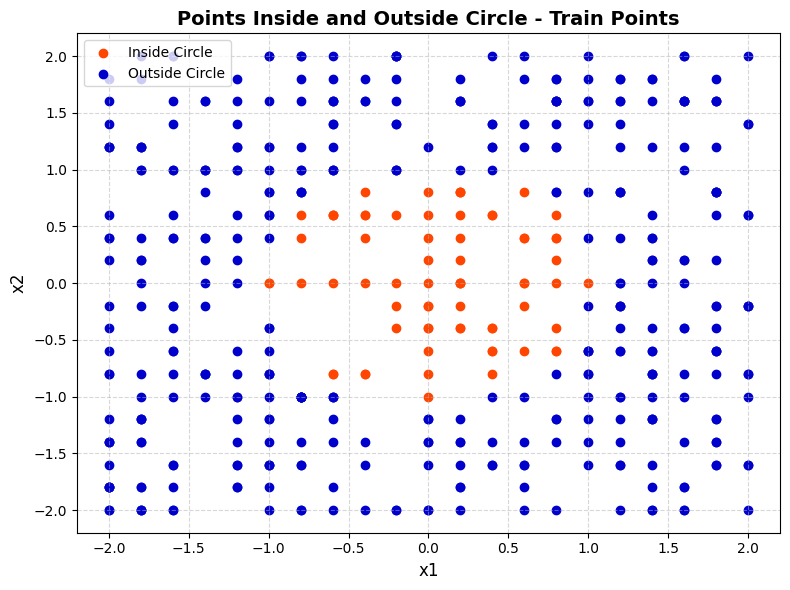

In [2819]:
plot(data,data_op_labels,1)

In [2820]:
train_data,op_labels,val_data,val_op_labels=train_test_split(data,data_op_labels)

In [2821]:
# select_randomly(train_data)

In [2822]:
# rbf_centres_random(train_data)

In [2823]:
print("Shape of train data :",train_data.shape)
print("Shape of train labels :",op_labels.shape)
print("Shape of val data :",val_data.shape)
print("Shape of val labels :",val_op_labels.shape)

Shape of train data : (352, 2)
Shape of train labels : (352, 1)
Shape of val data : (89, 2)
Shape of val labels : (89, 1)


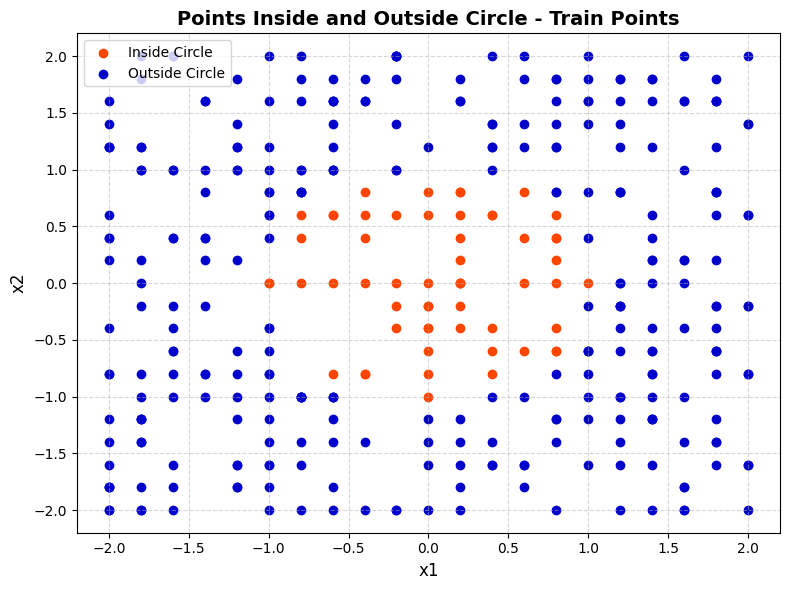

In [2824]:
plot(train_data,op_labels,1)

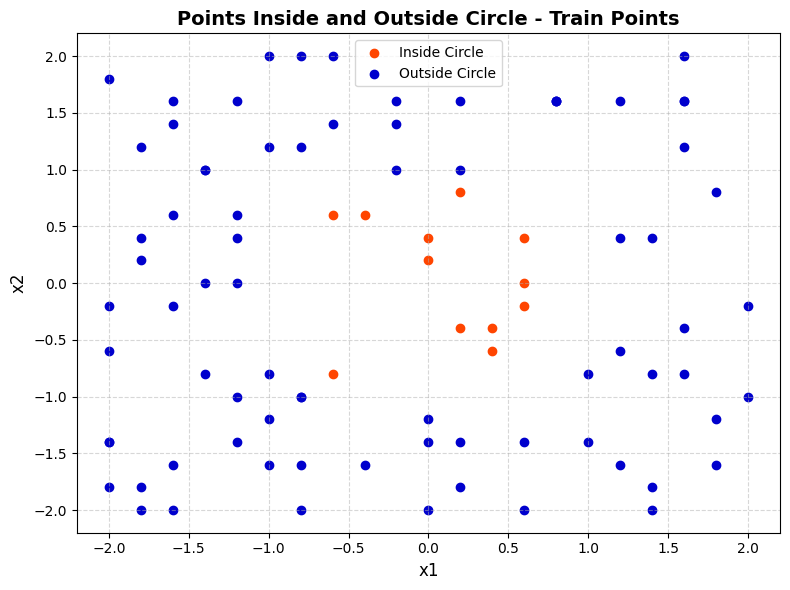

In [2825]:
plot(val_data,val_op_labels,1)

## Question 1

## Training

In [2826]:
output_1=[]

for sigma in sigma_list:
    weight,output=RBF_NN(train_data,op_labels,sigma,1)
    output_1.append(output)
    weights_1.append(weight)

Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi is: (352, 352)
Shape of weights is: (352, 1)
Shape of phi i

In [2827]:
len(weights_1)

20

In [2828]:
type(weights_1[0])

numpy.ndarray

In [2829]:
weights_1[0].shape

(352, 1)

In [2830]:
accuracy_list_1

[100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 99.43181818181817,
 99.7159090909091,
 100.0,
 100.0,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091]

In [2831]:
len(accuracy_list_1)

20

## Sigma vs Accuracy Plot

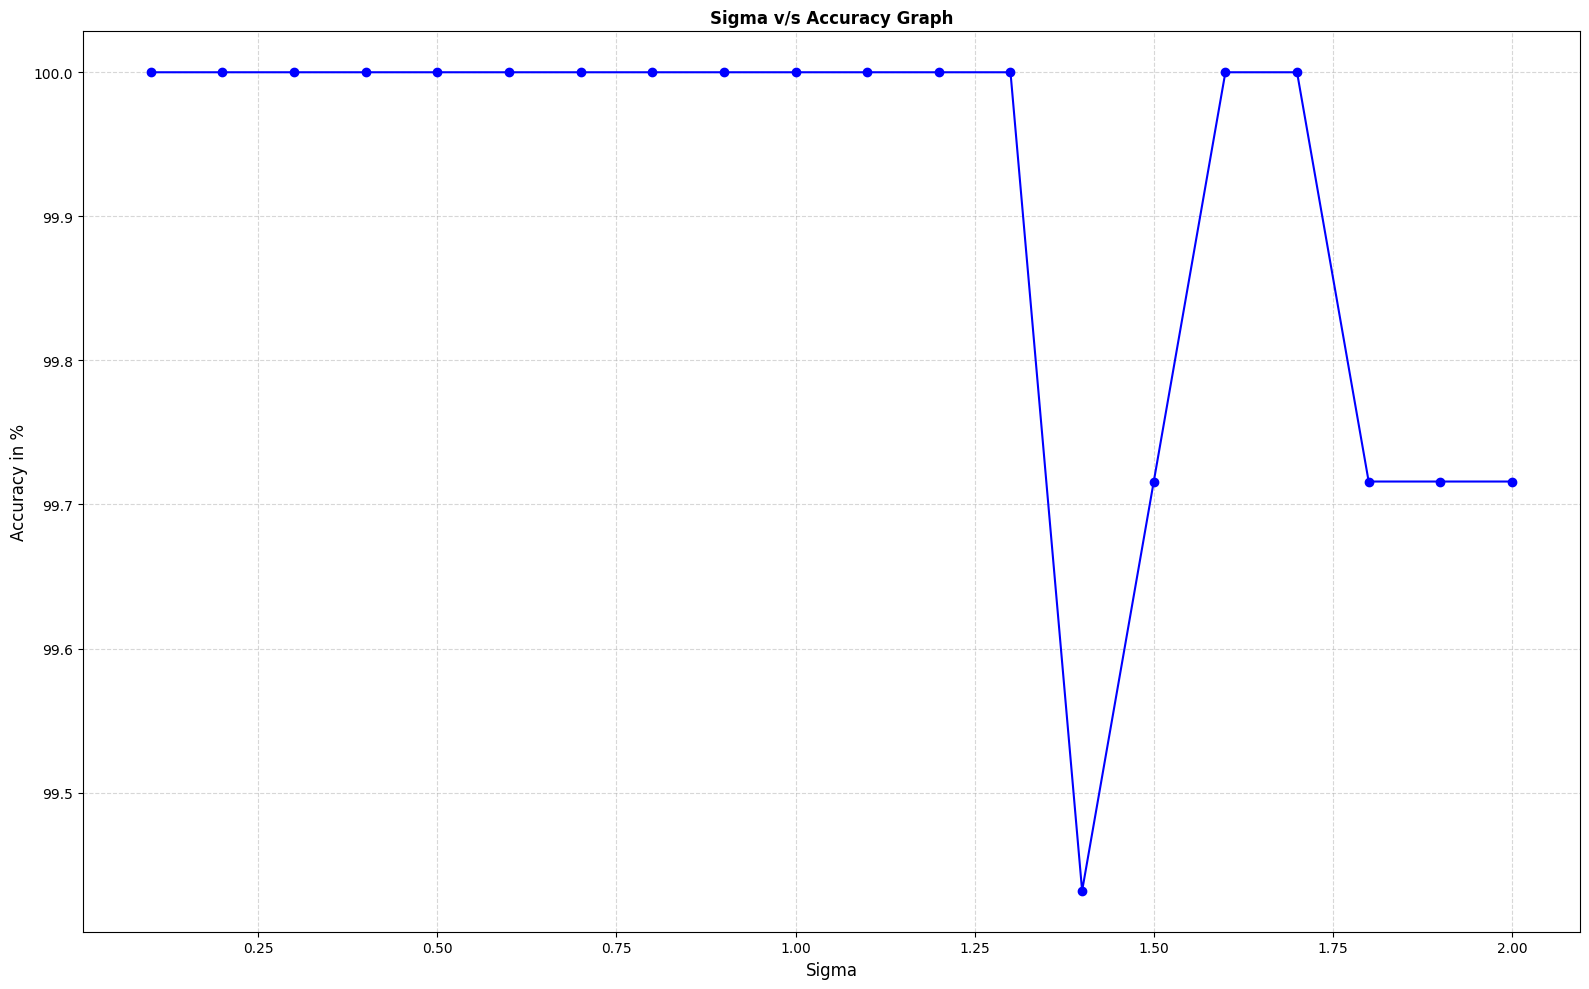

In [2832]:
acc_mse_plot(accuracy_list_1,sigma_list)

## Sigma vs MSE plot

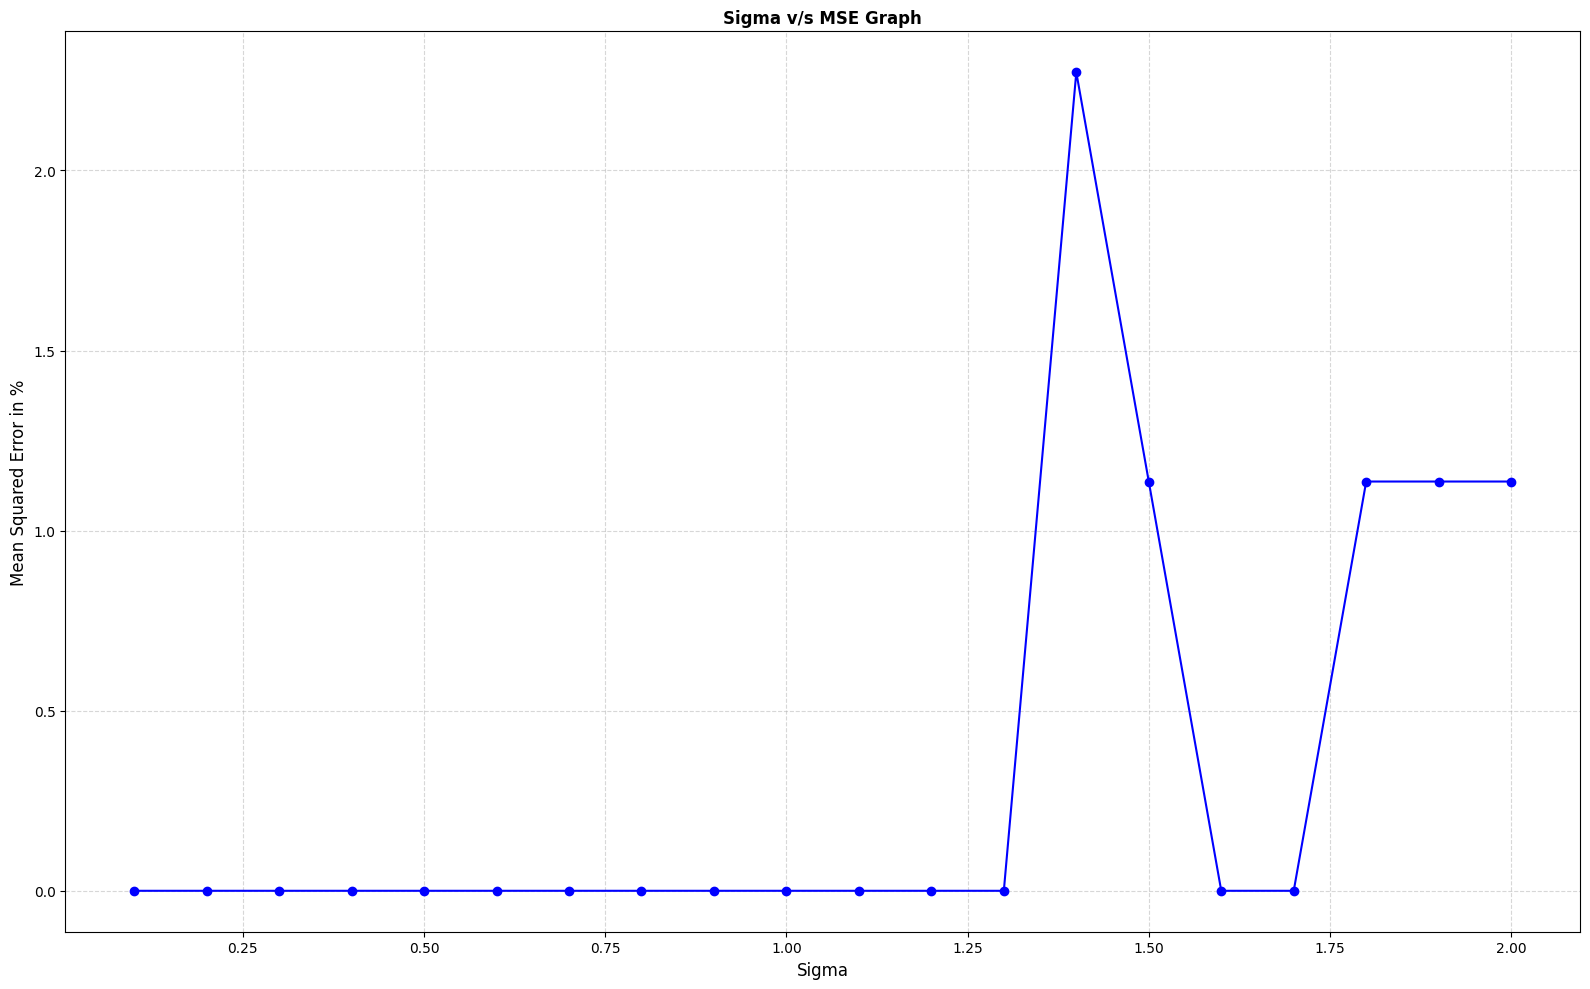

In [2833]:
acc_mse_plot(mse_list_1,sigma_list,mse=True)

## Plot Graph for Q1 at sigma with max accuracy 

20
100.0
0


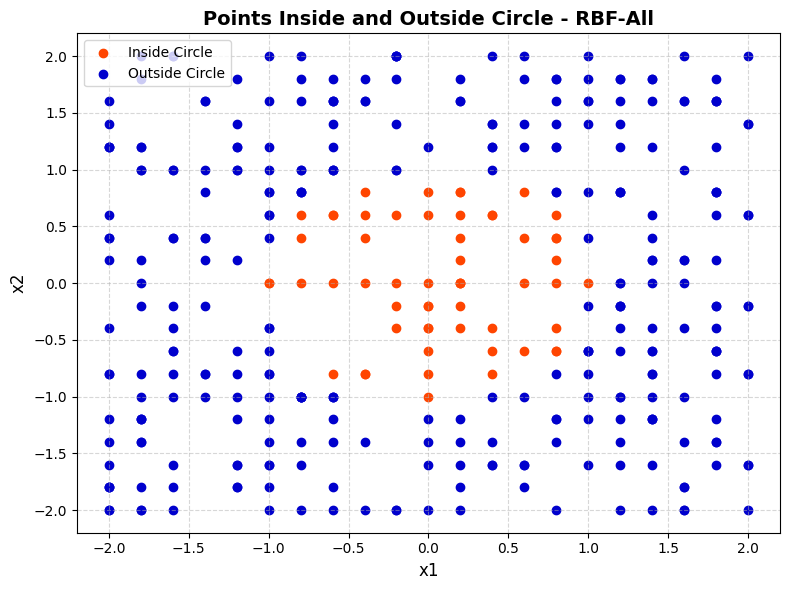

In [2834]:
print(len(output_1))
print(max(accuracy_list_1))
print(accuracy_list_1.index(max(accuracy_list_1)))
# for output in output_1:
plot(train_data,output_1[accuracy_list_1.index(max(accuracy_list_1))],2)


In [2835]:
weights_1[0]


array([[-0.43404449],
       [-0.31811167],
       [-0.20997385],
       [ 1.05215989],
       [ 0.79074841],
       [-0.77158882],
       [-0.48320366],
       [-0.22069108],
       [ 0.89918859],
       [-0.25852299],
       [-0.6807917 ],
       [-0.4423322 ],
       [-0.86453115],
       [-0.38497109],
       [-0.43423975],
       [-0.87818733],
       [-0.7657103 ],
       [-0.38882847],
       [ 1.14403645],
       [-0.75883471],
       [-0.38691334],
       [ 0.42908977],
       [-0.75695985],
       [-0.84925055],
       [ 0.75178361],
       [-0.31673544],
       [-0.67116607],
       [-0.5857323 ],
       [-0.44035693],
       [ 0.37539819],
       [-0.3009766 ],
       [-0.65473869],
       [-0.78942779],
       [-0.34705029],
       [-0.67950925],
       [-0.86036158],
       [-0.28759628],
       [-0.39465137],
       [-0.77355615],
       [-0.56398104],
       [ 0.6921436 ],
       [-0.84654227],
       [-0.88221484],
       [ 0.79276363],
       [ 0.78605443],
       [-0

## Validation

In [2836]:
val_output_1=[]
for sigma in sigma_list:
    val_output_1=RBF_NN_predict(train_data,weights_1[0],val_data,val_op_labels,sigma,1)
#     tst_accuracy_list_1.append(val_output_1)

Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is: (89, 352)
Shape of rbf output is: (89, 352)
Shape of rbf centres is: (352, 2)
Shape of phi is:

In [2837]:
tst_accuracy_list_1

[100.0,
 100.0,
 98.87640449438202,
 98.87640449438202,
 98.87640449438202,
 97.75280898876404,
 94.3820224719101,
 89.8876404494382,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427]

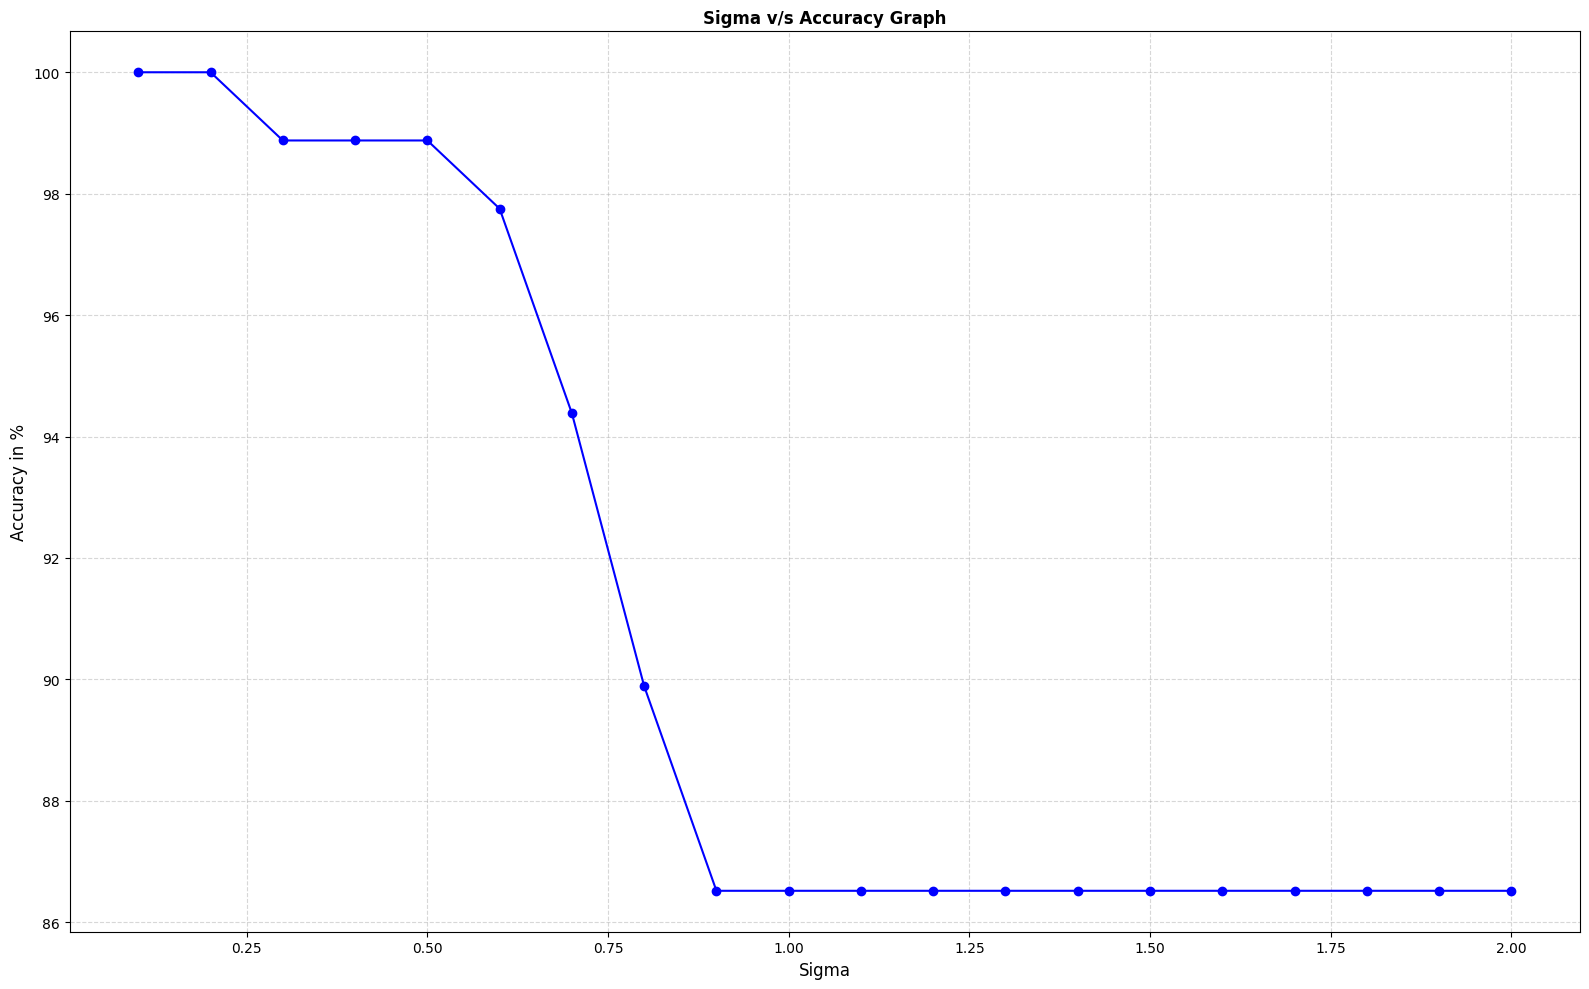

In [2838]:
acc_mse_plot(tst_accuracy_list_1,sigma_list)

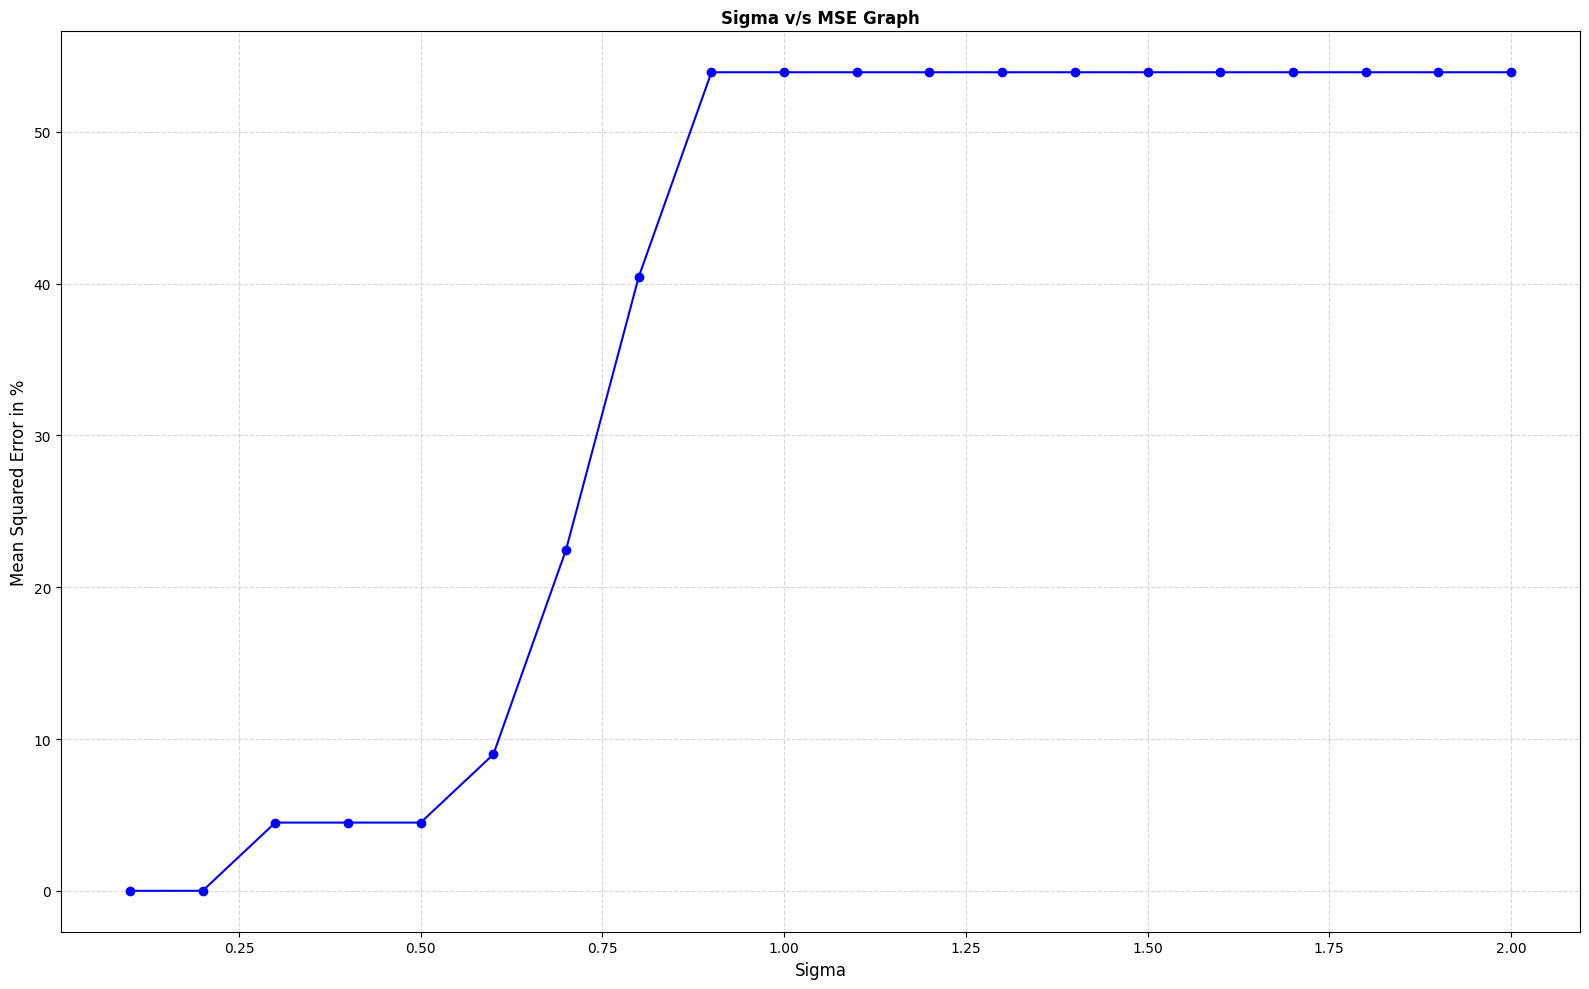

In [2839]:
acc_mse_plot(tst_mse_list_1,sigma_list,mse=True)

## Question 2


## Train

In [2840]:
outputs_2=[]

for sigma in sigma_list:
    weight,output=RBF_NN(train_data,op_labels,sigma,2)
    outputs_2.append(output)
    weights_2.append(weight)

Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi i

In [2841]:
accuracy_list_2

[96.5909090909091,
 100.0,
 100.0,
 100.0,
 100.0,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 100.0,
 99.7159090909091,
 100.0,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091]

In [2842]:
len(accuracy_list_2)

20

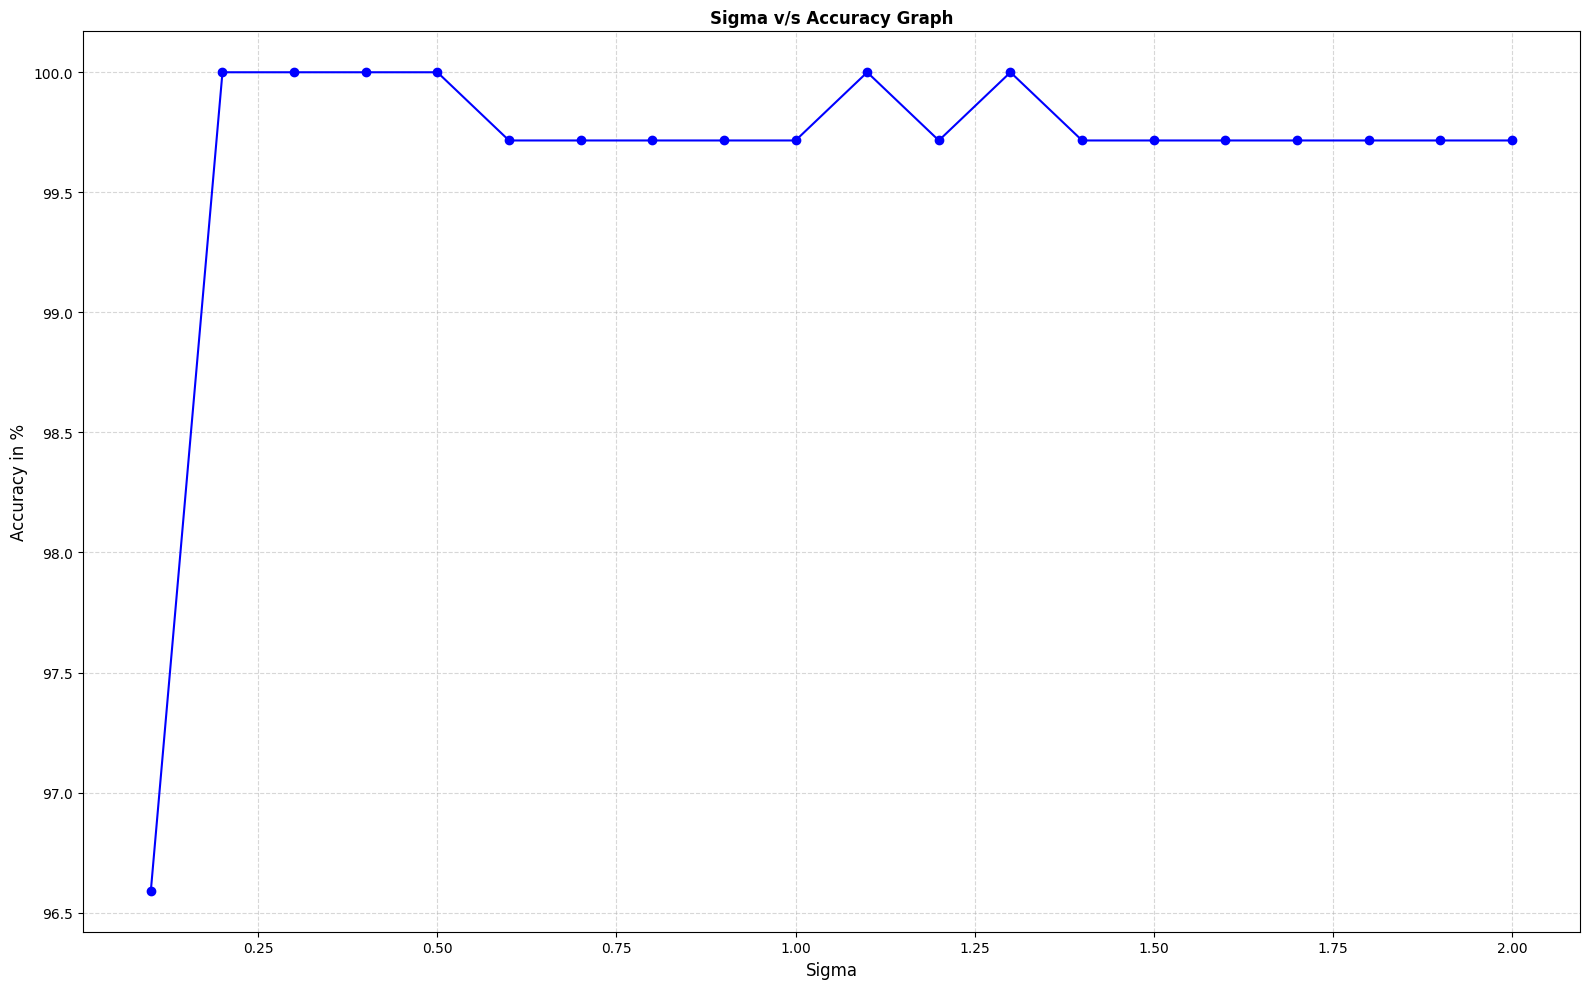

In [2843]:
acc_plot(accuracy_list_2,sigma_list)

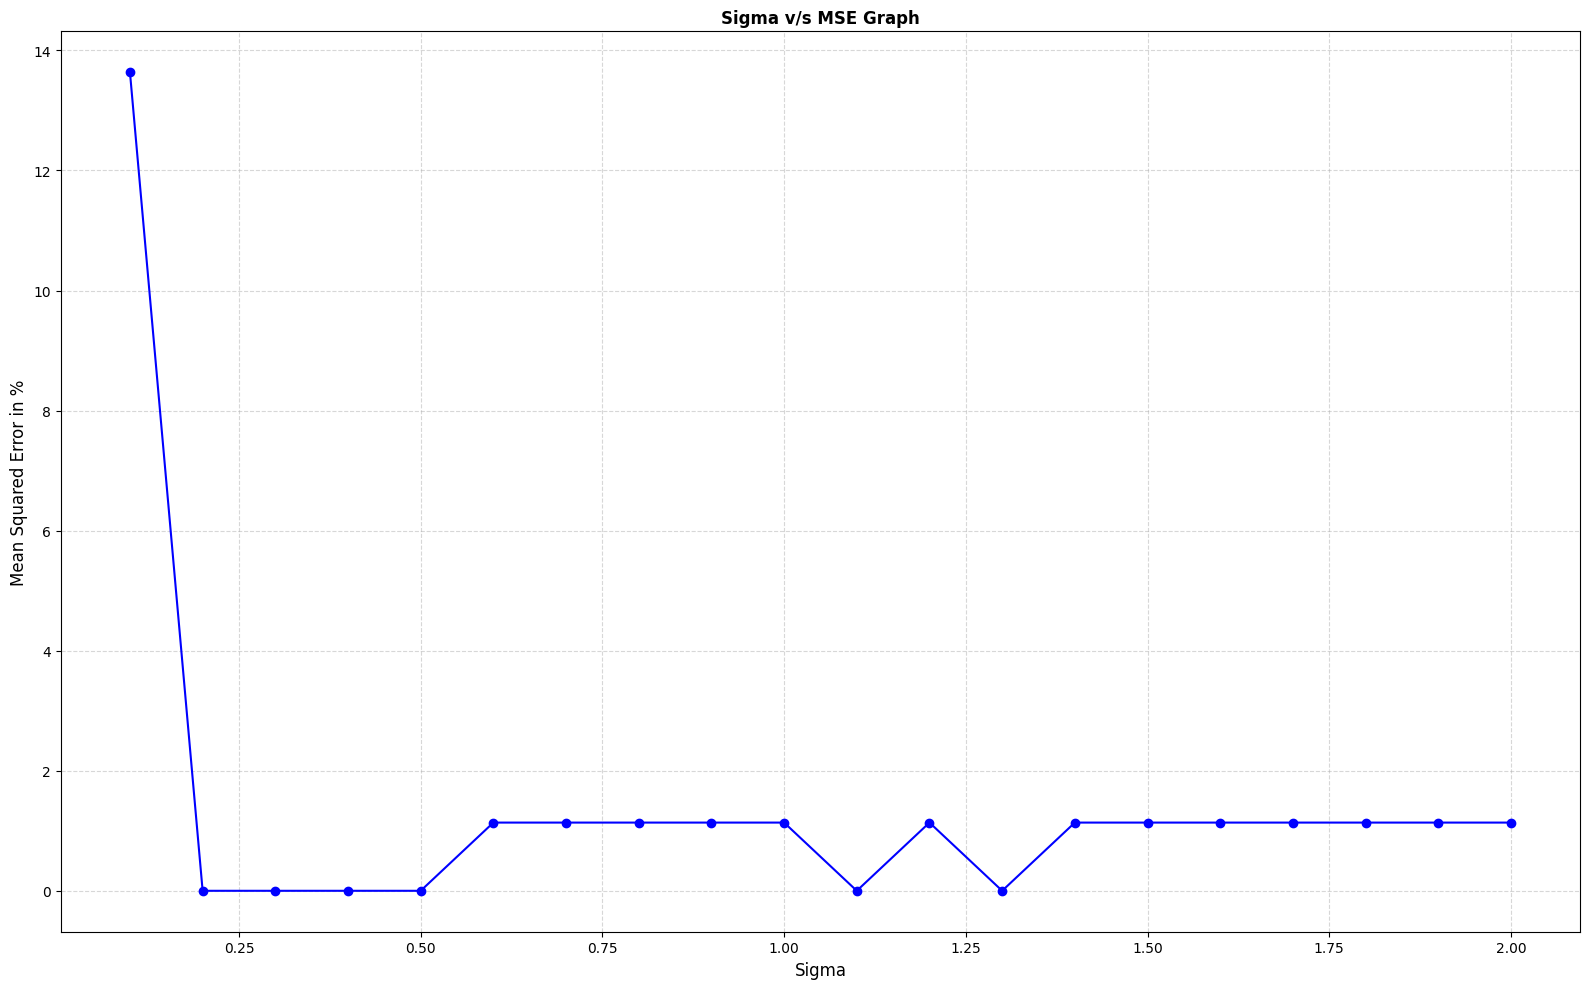

In [2844]:
acc_mse_plot(mse_list_2,sigma_list,mse=True)

In [2845]:
# print(len(output_2))
# print(max(accuracy_list_2))
# # for output in output_1:
# plot(train_data,output_2[accuracy_list_2.index(max(accuracy_list_2))],3)

In [2846]:
weights_2[0].shape

(150, 1)

## Validation

In [2847]:
val_output_2=[]
for sigma in sigma_list:
    out=(RBF_NN_predict(train_data,weights_2[0],val_data,val_op_labels,sigma,2))
    val_output_2.append(out)
    

Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)
Shape of rbf centres is: (150, 2)
Shape of phi is:

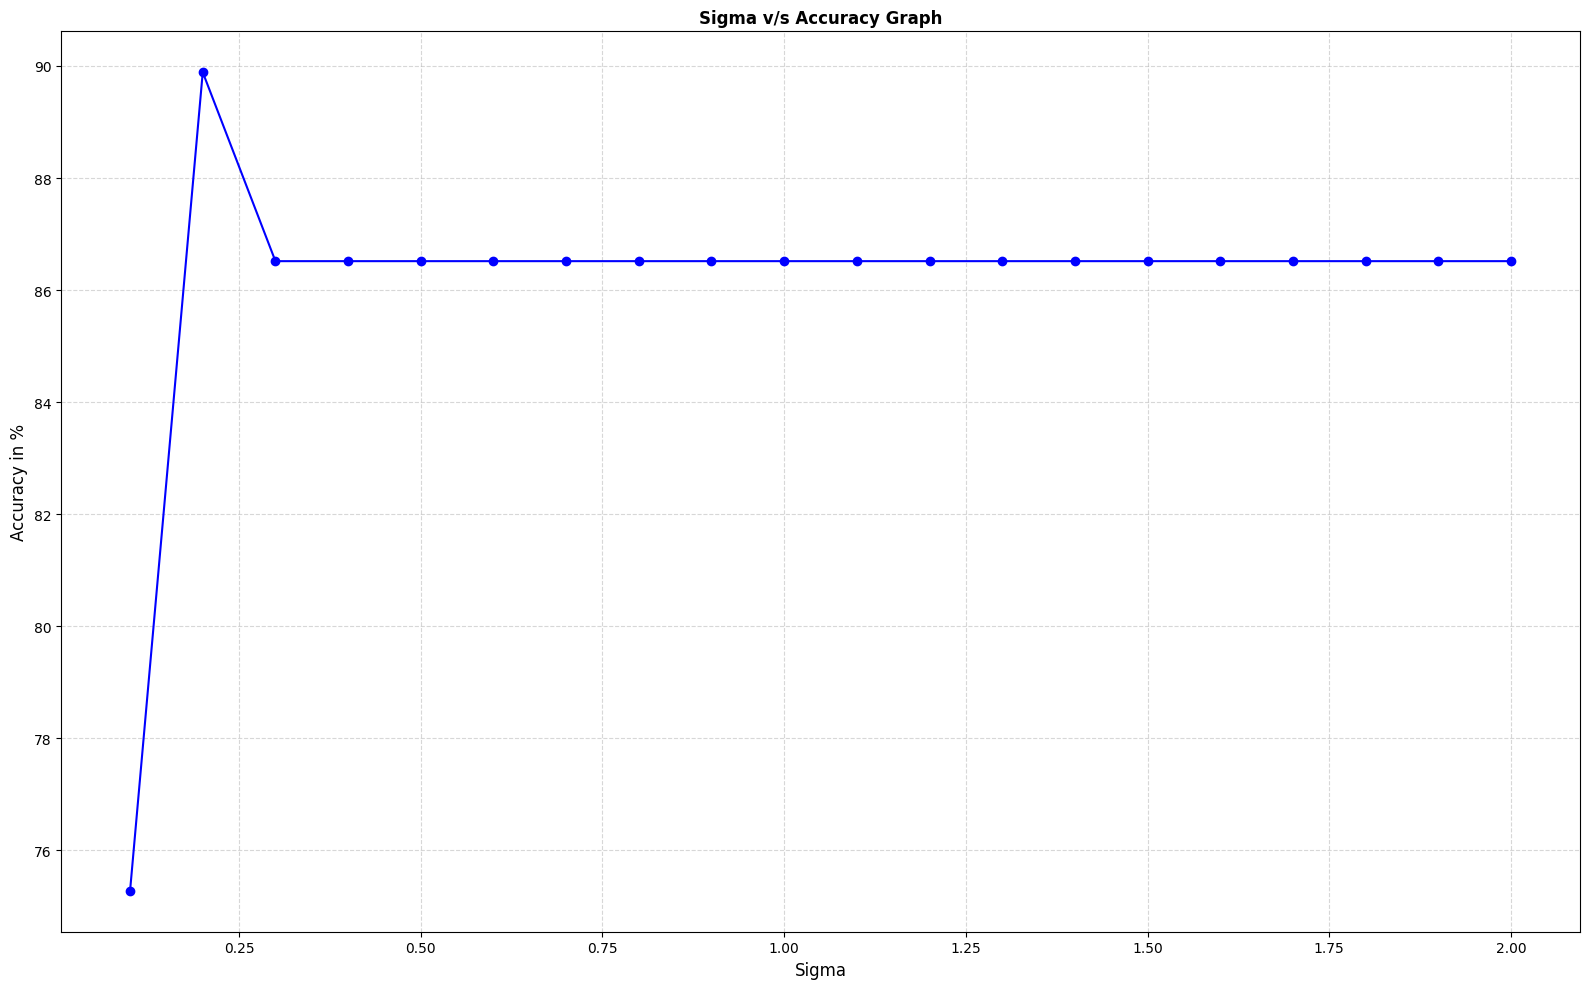

In [2848]:
acc_mse_plot(tst_accuracy_list_2,sigma_list)

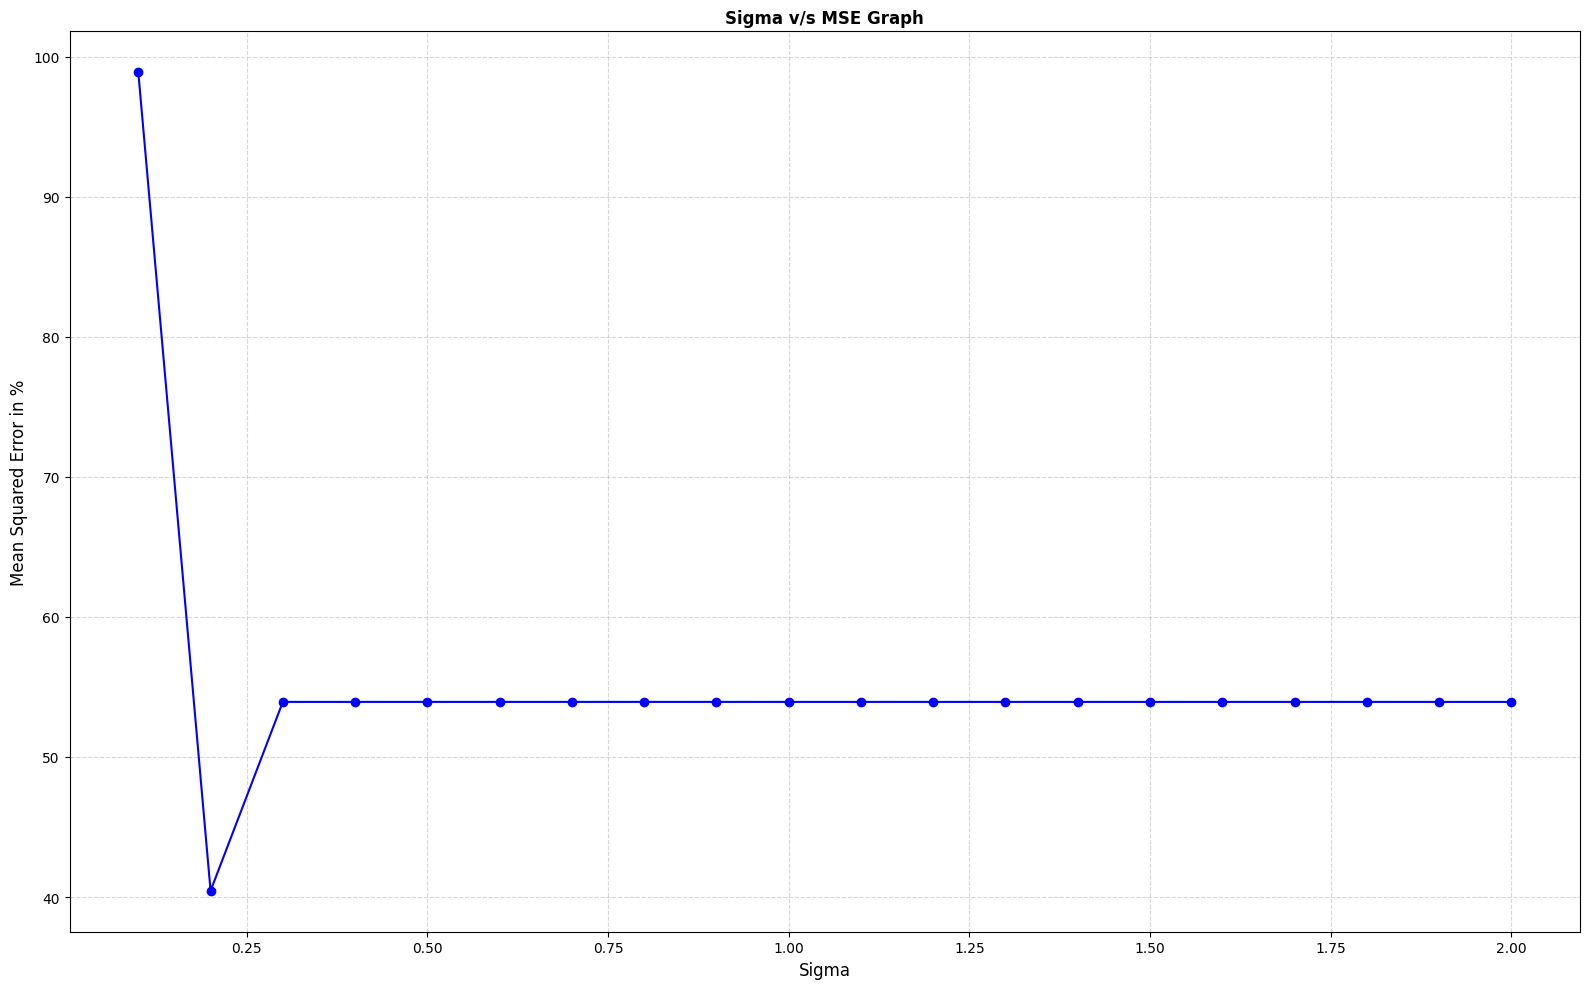

In [2849]:
acc_mse_plot(tst_mse_list_2,sigma_list,mse=True)

## Question 3

In [2850]:
output_3=[]

for sigma in sigma_list:
    weight,output=RBF_NN(train_data,op_labels,sigma,3,K=150)
    output_3.append(output)
    weights_3.append(weight)
    

/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of phi is: (352, 150)
Shape of weights is: (150, 1)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of phi is: (352, 150)
Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)
Shape of phi is: (352, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of weights is: (150, 1)


In [2851]:
accuracy_list_3

[98.01136363636364,
 99.7159090909091,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 100.0,
 99.7159090909091,
 99.7159090909091,
 99.43181818181817,
 100.0,
 100.0,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091,
 99.7159090909091]

In [2852]:
len(accuracy_list_3)

20

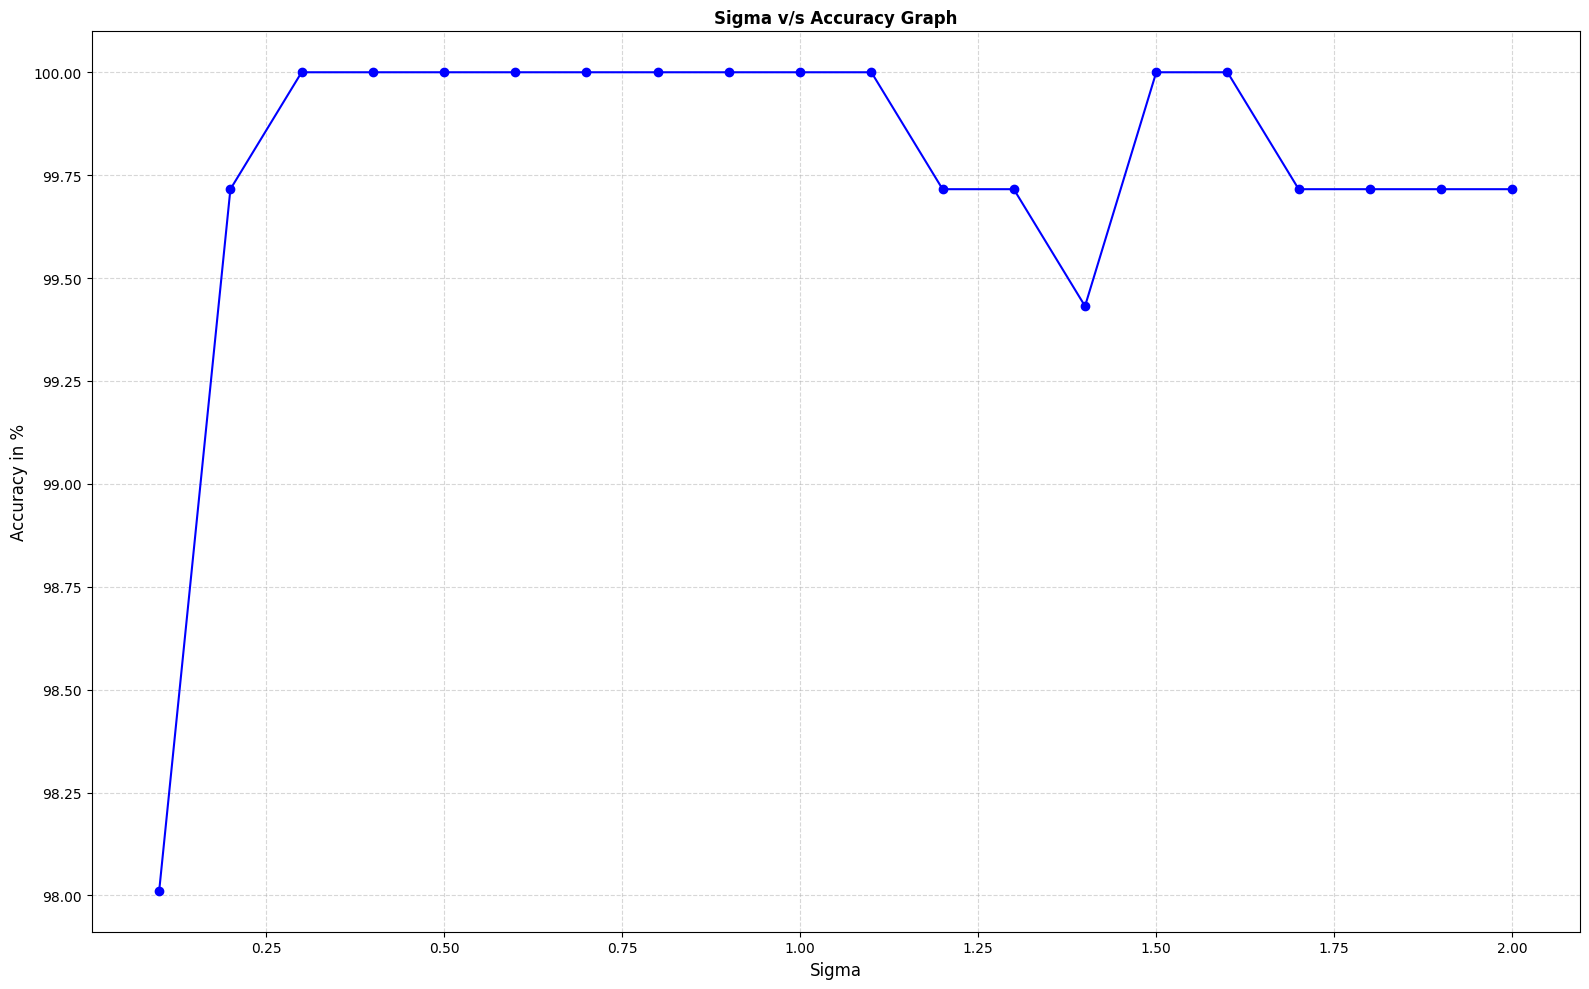

In [2853]:
acc_plot(accuracy_list_3,sigma_list)

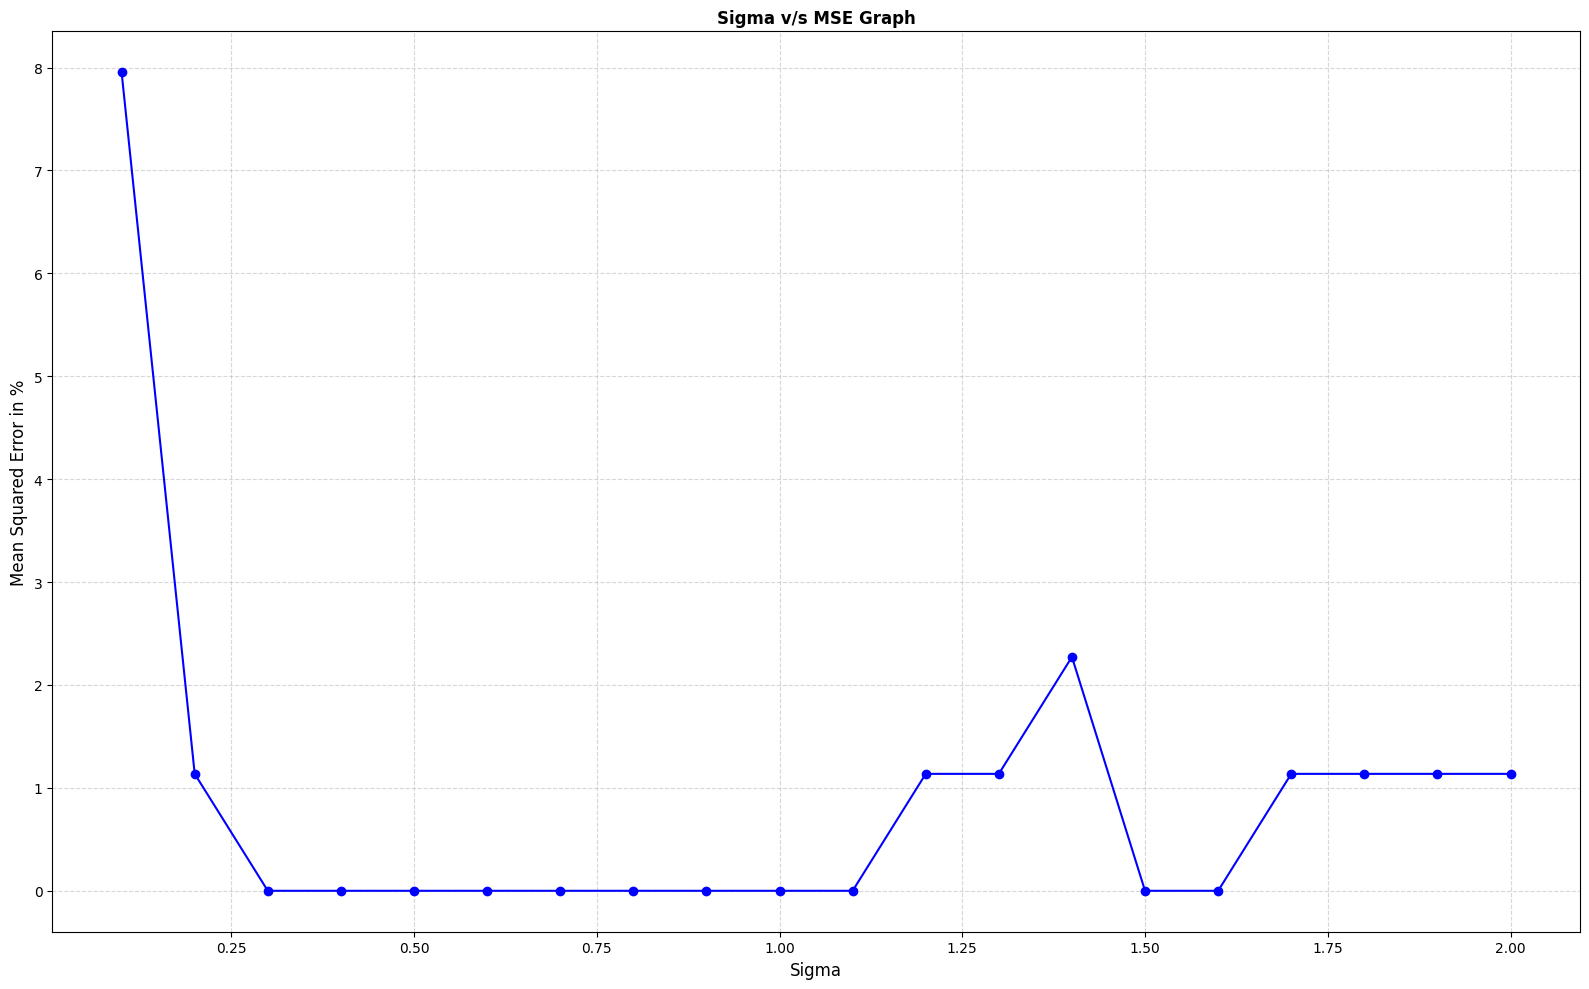

In [2854]:
acc_mse_plot(mse_list_3,sigma_list,mse=True)

20
100.0


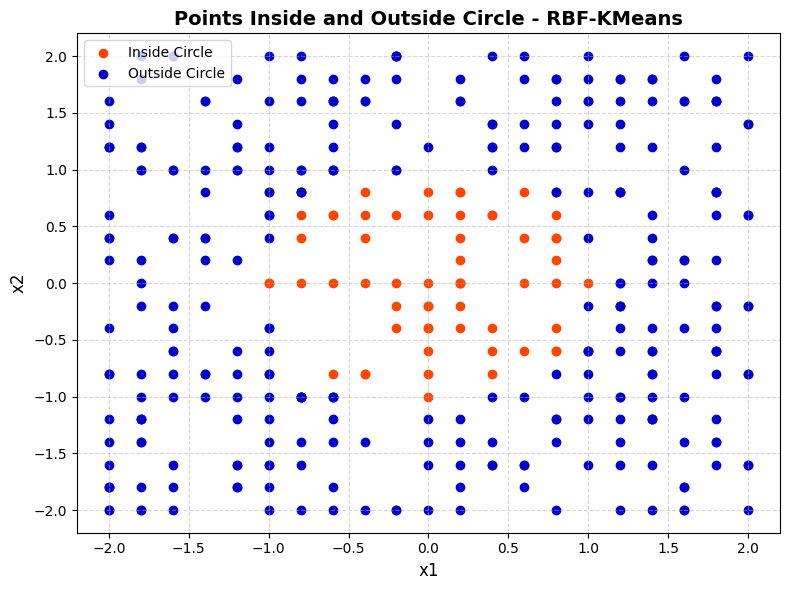

In [2855]:
print(len(output_3))
print(max(accuracy_list_3))
# for output in output_1:
plot(train_data,output_3[accuracy_list_3.index(max(accuracy_list_3))],4)

In [2856]:
len(weights_3)

20

## Validation

In [2857]:
val_output_3=[]
for sigma in sigma_list:
    val_output_3=RBF_NN_predict(train_data,weights_3[0],val_data,val_op_labels,sigma,3,K=150)
    

/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


/Users/ursuladas/opt/anaconda3/envs/ece657_env/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Shape of rbf centres is: (150, 2)
Shape of phi is: (89, 150)
Shape of rbf output is: (89, 150)


In [2858]:
tst_accuracy_list_3

[98.87640449438202,
 100.0,
 98.87640449438202,
 98.87640449438202,
 97.75280898876404,
 96.62921348314607,
 93.25842696629213,
 88.76404494382022,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427,
 86.51685393258427]

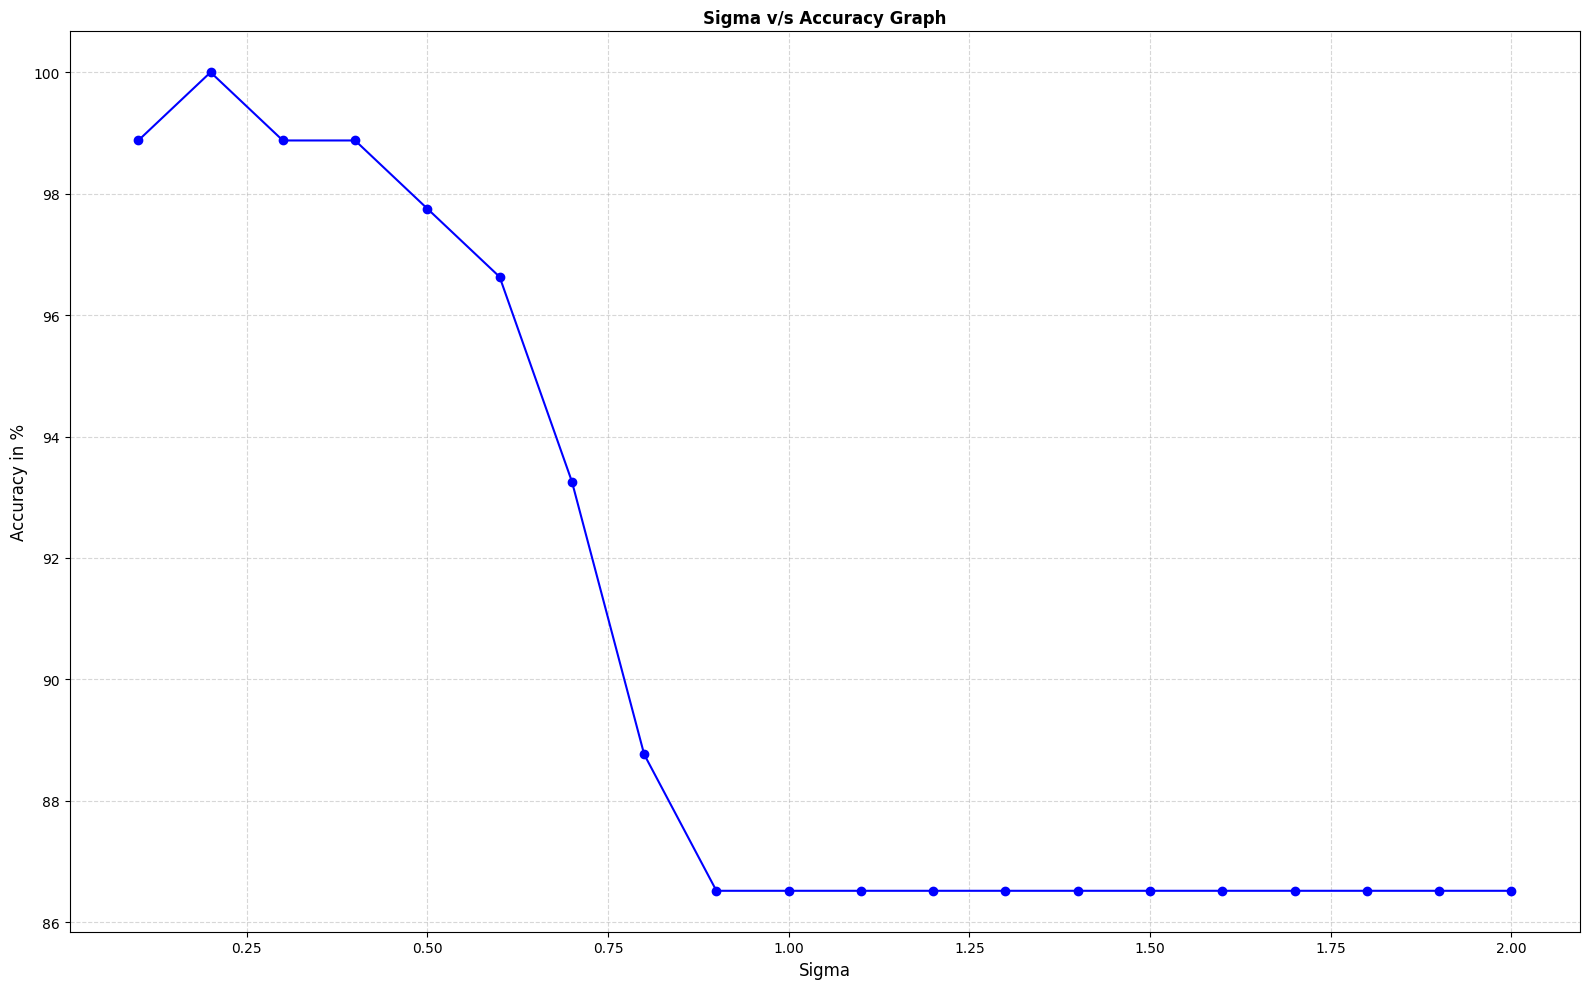

In [2859]:
acc_mse_plot(tst_accuracy_list_3,sigma_list)

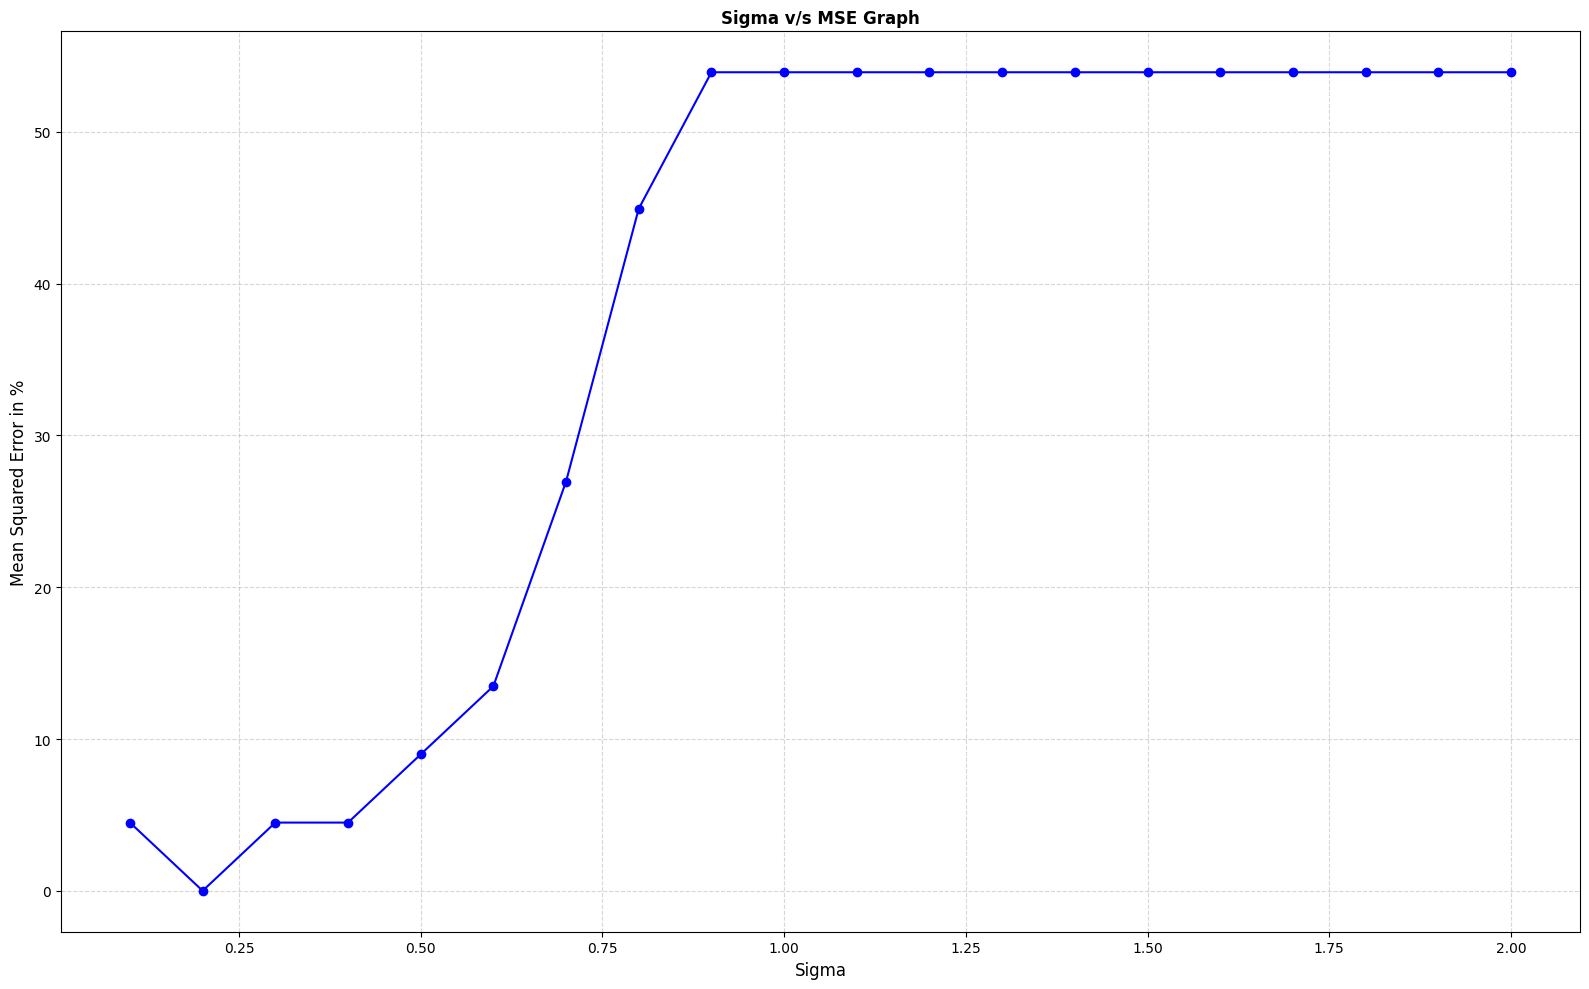

In [2860]:
acc_mse_plot(tst_mse_list_3,sigma_list,mse=True)

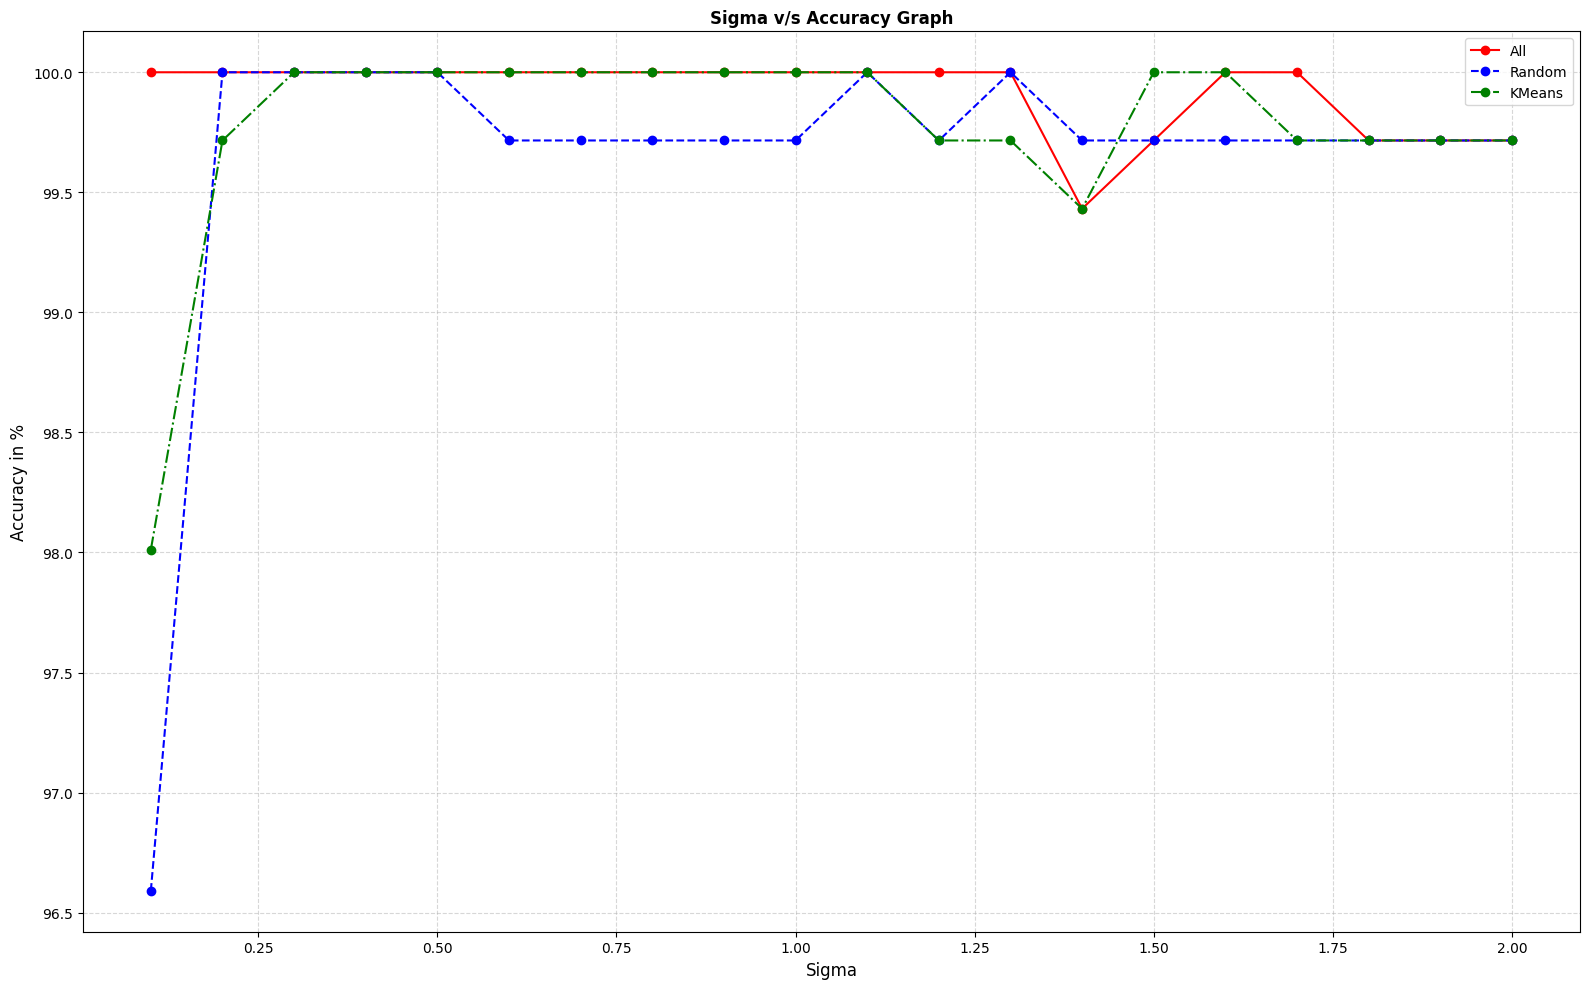

In [2861]:
comp_plot(accuracy_list_1,accuracy_list_2,accuracy_list_3,sigma_list)

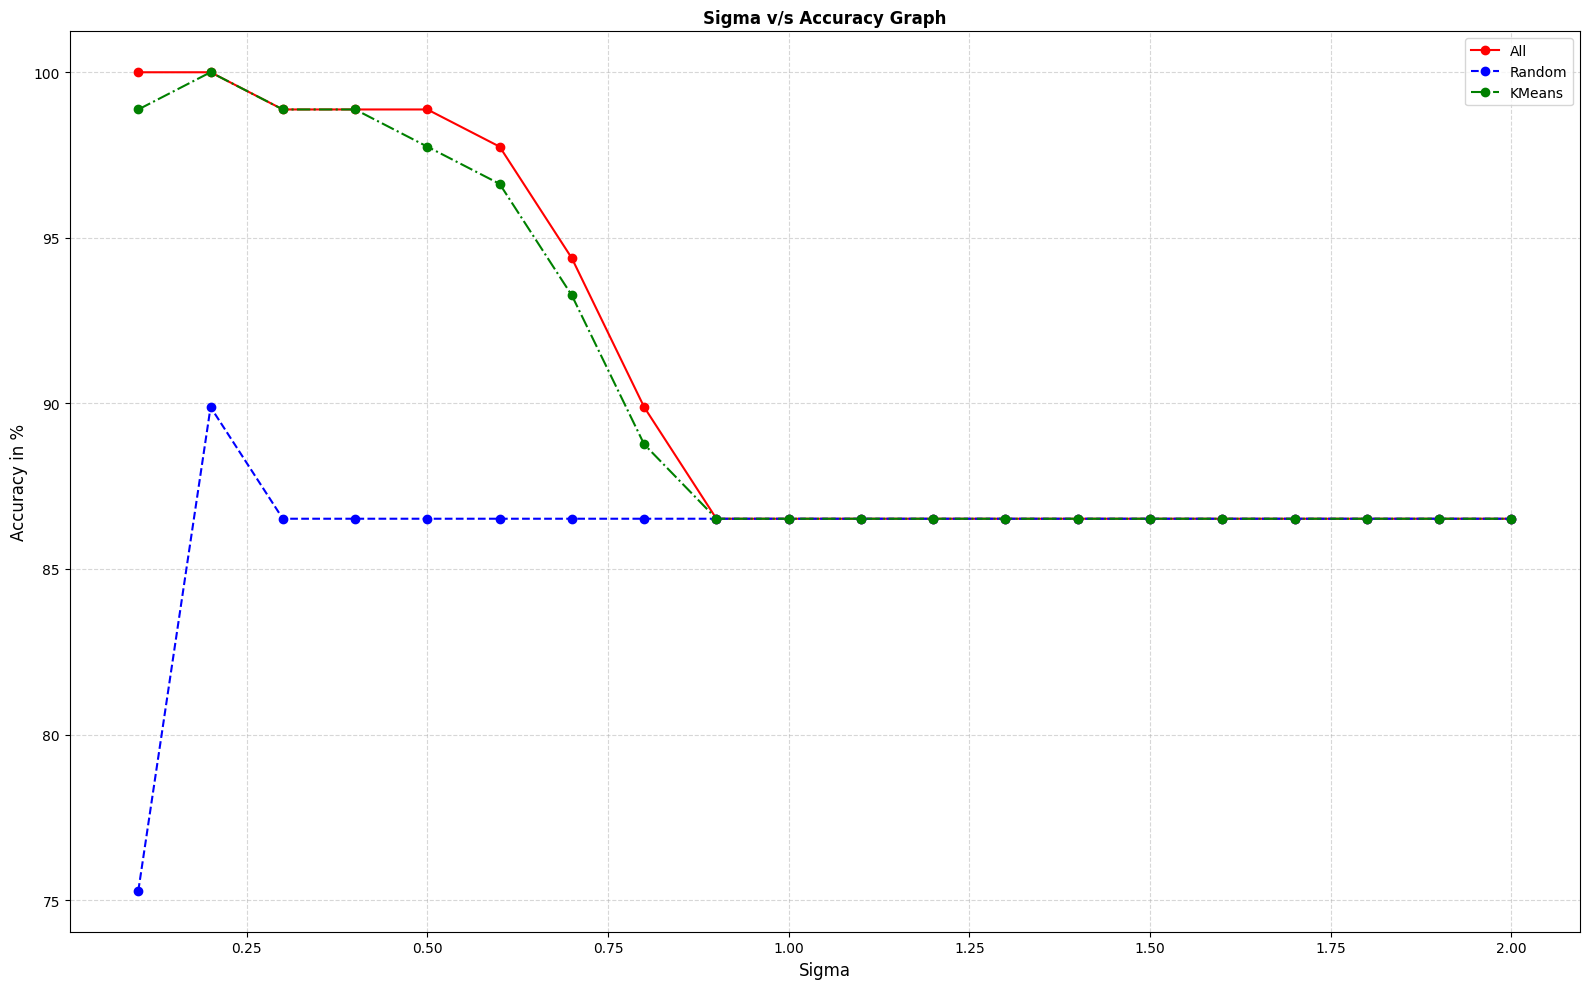

In [2862]:
comp_plot(tst_accuracy_list_1,tst_accuracy_list_2,tst_accuracy_list_3,sigma_list)

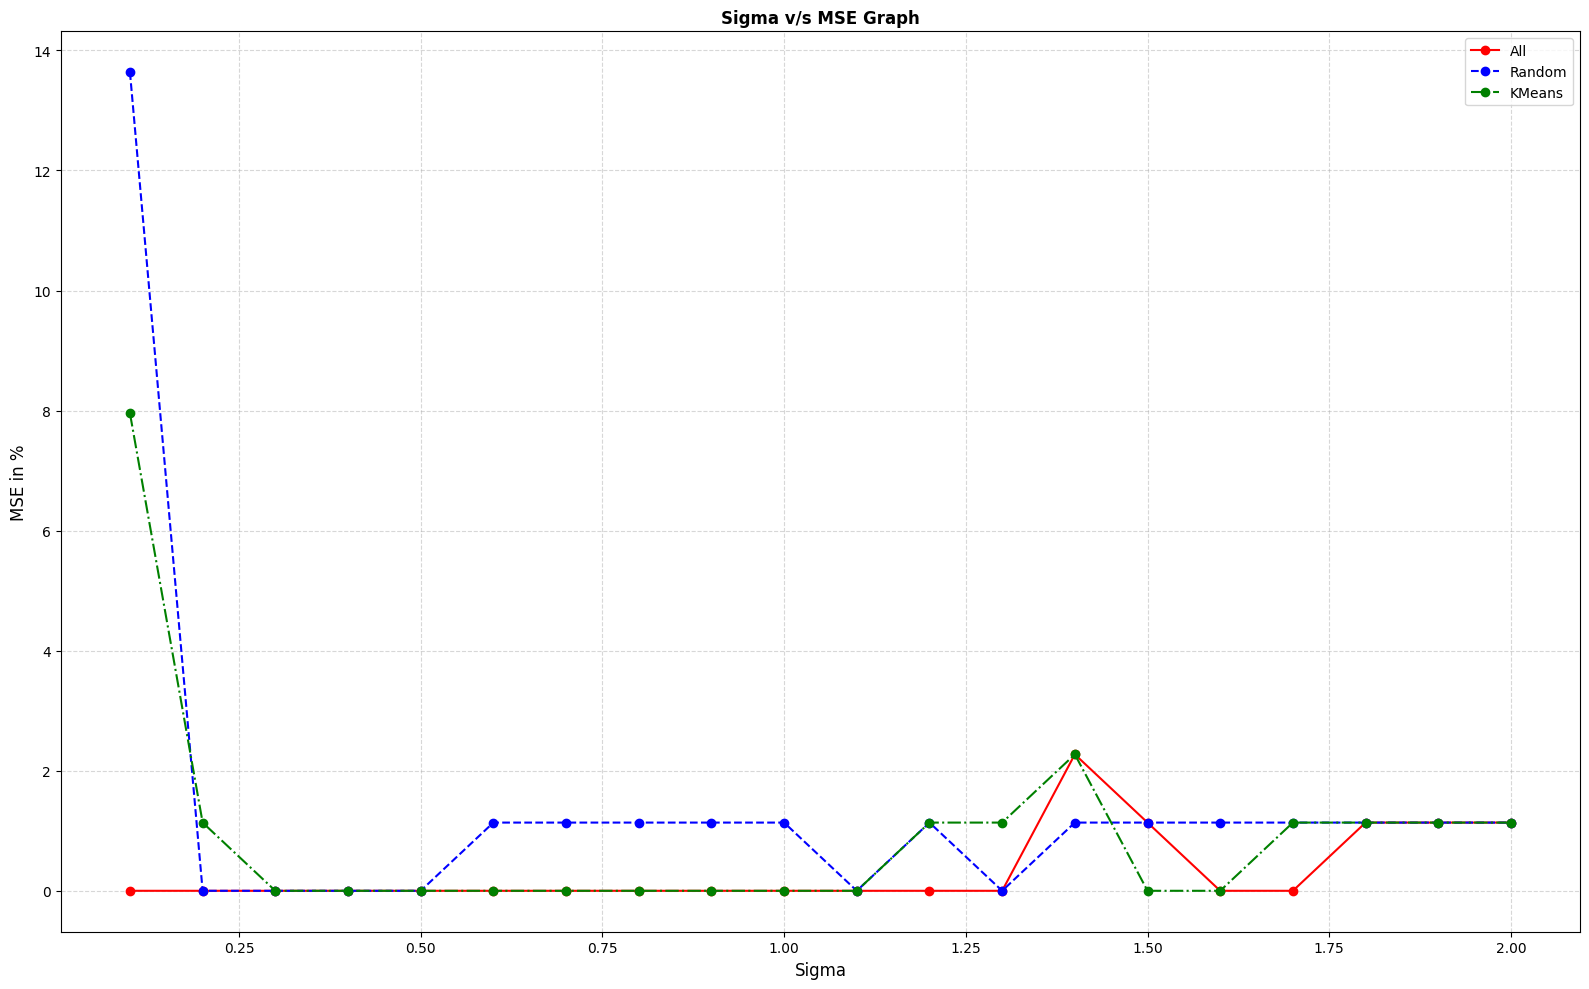

In [2863]:
comp_plot(tst_mse_list_1,tst_mse_list_2,tst_mse_list_3,sigma_list,mse=True)

In [2864]:
acc_df={'Sigma':sigma_list,'All':accuracy_list_1,'Random':accuracy_list_2,'KMeans':accuracy_list_3}
pd.DataFrame(acc_df)

,Sigma,All,Random,KMeans
0,0.1,100.000000,96.590909,98.011364
1,0.2,100.000000,100.000000,99.715909
2,0.3,100.000000,100.000000,100.000000
3,0.4,100.000000,100.000000,100.000000
4,0.5,100.000000,100.000000,100.000000
5,0.6,100.000000,99.715909,100.000000
6,0.7,100.000000,99.715909,100.000000
7,0.8,100.000000,99.715909,100.000000
8,0.9,100.000000,99.715909,100.000000
9,1.0,100.000000,99.715909,100.000000


In [2865]:
tst_acc_df={'Sigma':sigma_list,'All':tst_accuracy_list_1,'Random':tst_accuracy_list_2,'KMeans':tst_accuracy_list_3}
pd.DataFrame(tst_acc_df)

,Sigma,All,Random,KMeans
0,0.1,100.000000,75.280899,98.876404
1,0.2,100.000000,89.887640,100.000000
2,0.3,98.876404,86.516854,98.876404
3,0.4,98.876404,86.516854,98.876404
4,0.5,98.876404,86.516854,97.752809
5,0.6,97.752809,86.516854,96.629213
6,0.7,94.382022,86.516854,93.258427
7,0.8,89.887640,86.516854,88.764045
8,0.9,86.516854,86.516854,86.516854
9,1.0,86.516854,86.516854,86.516854
